<a href="https://colab.research.google.com/github/Wen9324/Game_of_Thrones-AnalysisCharacterMortality/blob/main/Game_of_Thrones_%E4%BA%BA%E7%89%A9%E6%AD%BB%E4%BA%A1%E7%8E%87%E5%88%86%E6%9E%90%E5%8F%8A%E9%A0%90%E6%B8%AC_%E6%BA%AB%E9%83%81%E7%B6%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 應用決策樹(DecisionTree)於 Game of Thrones死亡率分析及預測
###資料集來源：https://www.kaggle.com/datasets/mylesoneill/game-of-thrones

In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/python/character-deaths.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                917 non-null    object 
 1   Allegiances         917 non-null    object 
 2   Death Year          305 non-null    float64
 3   Book of Death       307 non-null    float64
 4   Death Chapter       299 non-null    float64
 5   Book Intro Chapter  905 non-null    float64
 6   Gender              917 non-null    int64  
 7   Nobility            917 non-null    int64  
 8   GoT                 917 non-null    int64  
 9   CoK                 917 non-null    int64  
 10  SoS                 917 non-null    int64  
 11  FfC                 917 non-null    int64  
 12  DwD                 917 non-null    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 93.3+ KB


In [ ]:
df.isnull()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,False,False,True,True,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,True,True,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,True,True,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,False,False,True,True,True,False,False,False,False,False,False,False,False
913,False,False,False,False,False,False,False,False,False,False,False,False,False
914,False,False,False,False,False,False,False,False,False,False,False,False,False
915,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df.isnull().sum()

Name                    0
Allegiances             0
Death Year            612
Book of Death         610
Death Chapter         618
Book Intro Chapter     12
Gender                  0
Nobility                0
GoT                     0
CoK                     0
SoS                     0
FfC                     0
DwD                     0
dtype: int64

# 缺失值填補

有空值的其中三個欄位：「死亡年份」、「死亡集數」與「死亡章節」，對於最後預測的結果來說都是代表一樣的意思，不論是哪一年死亡，最後結果即為死亡，反之，就是存活，集數與章節亦同。因此可以選擇其中一個欄位，把空值的地方填入0，代表存活，有值的地方填入1，代表死亡。這樣一來就把資料集變得更簡潔了！

In [ ]:
df = df.rename(columns = {'Death Year':'Death'})
df['Death'] = df.Death.fillna(0)
df.Death[df.Death>0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


另外一個有空值的欄位「登場章節介紹」，我自作主張的把空值填入0，把原本有值的帶入1，這個想法是建立在，假設他有被慎重的介紹登場，或許死亡機率低一點，反之，沒有被好好介紹過的角色，可能是跑龍套隨便就死亡的機率高一些。

In [ ]:
df = df.rename(columns = {'Book Intro Chapter':'Intro'})
df['Intro'] = df.Intro.fillna(0)
df.Intro[df.Intro>0] = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Allegiances這個欄位是代表該角色效忠於哪一個家族，也是個挺重要的特徵，依據底下的值有幾種分類，會轉換成同樣數目的特徵欄位，每一欄位的值會再視其是否為該特徵，轉換成0或1。把這個欄位get dummy後，本來的資料集就會再增加約20種特徵。這時候來整理整理，把這些多出來的特徵欄位與原本的資料集合併，刪掉不會再用到的欄位。

In [ ]:
df1 = pd.get_dummies(df.Allegiances)
df = pd.concat([df, df1], axis = 1)
df = df.drop(['Allegiances','Book of Death', 'Death Chapter'], axis = 1)
df

,Name,Death,Intro,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,...,House Tyrell,Lannister,Martell,Night's Watch,None,Stark,Targaryen,Tully,Tyrell,Wildling
0,Addam Marbrand,0.0,1.0,1,1,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,Aegon Frey (Jinglebell),1.0,1.0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Aegon Targaryen,0.0,1.0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Adrack Humble,1.0,1.0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Aemon Costayne,0.0,0.0,1,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,Zollo,0.0,1.0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
913,Yurkhaz zo Yunzak,1.0,1.0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
914,Yezzan Zo Qaggaz,1.0,1.0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
915,Torwynd the Tame,1.0,1.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# 切割訓練集與測試集

首先，把x值(input)和y值(output)分離出來，要預測的結果為「Death」這個欄位，目前被放在第二欄，作為y，也就是說第3欄(Intro)以後的特徵值就是x值。在這邊使用iloc與loc兩個函數來抓取位置。
再使用sklearn的train_test_split函數，以隨機方式切分訓練集與測試集，在這篇的數量分配，75%為訓練集，25%為測試集。

In [ ]:
from sklearn.model_selection import train_test_split
x = df.iloc[:, 2:]
y = df.loc[:, 'Death']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

# 製作決策樹模型

接著就可以來套用DecitionTreeClassifier來製作決策樹模型！以下式子中有些網路教學會分成兩行寫，先建構這棵樹模型的樣子，限制模型深度為5層，不然會跑到天荒地老。接著再把模型拿去應用於訓練集上以進行訓練。

In [ ]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 0).fit(x_train, y_train)

# 將樹可視化

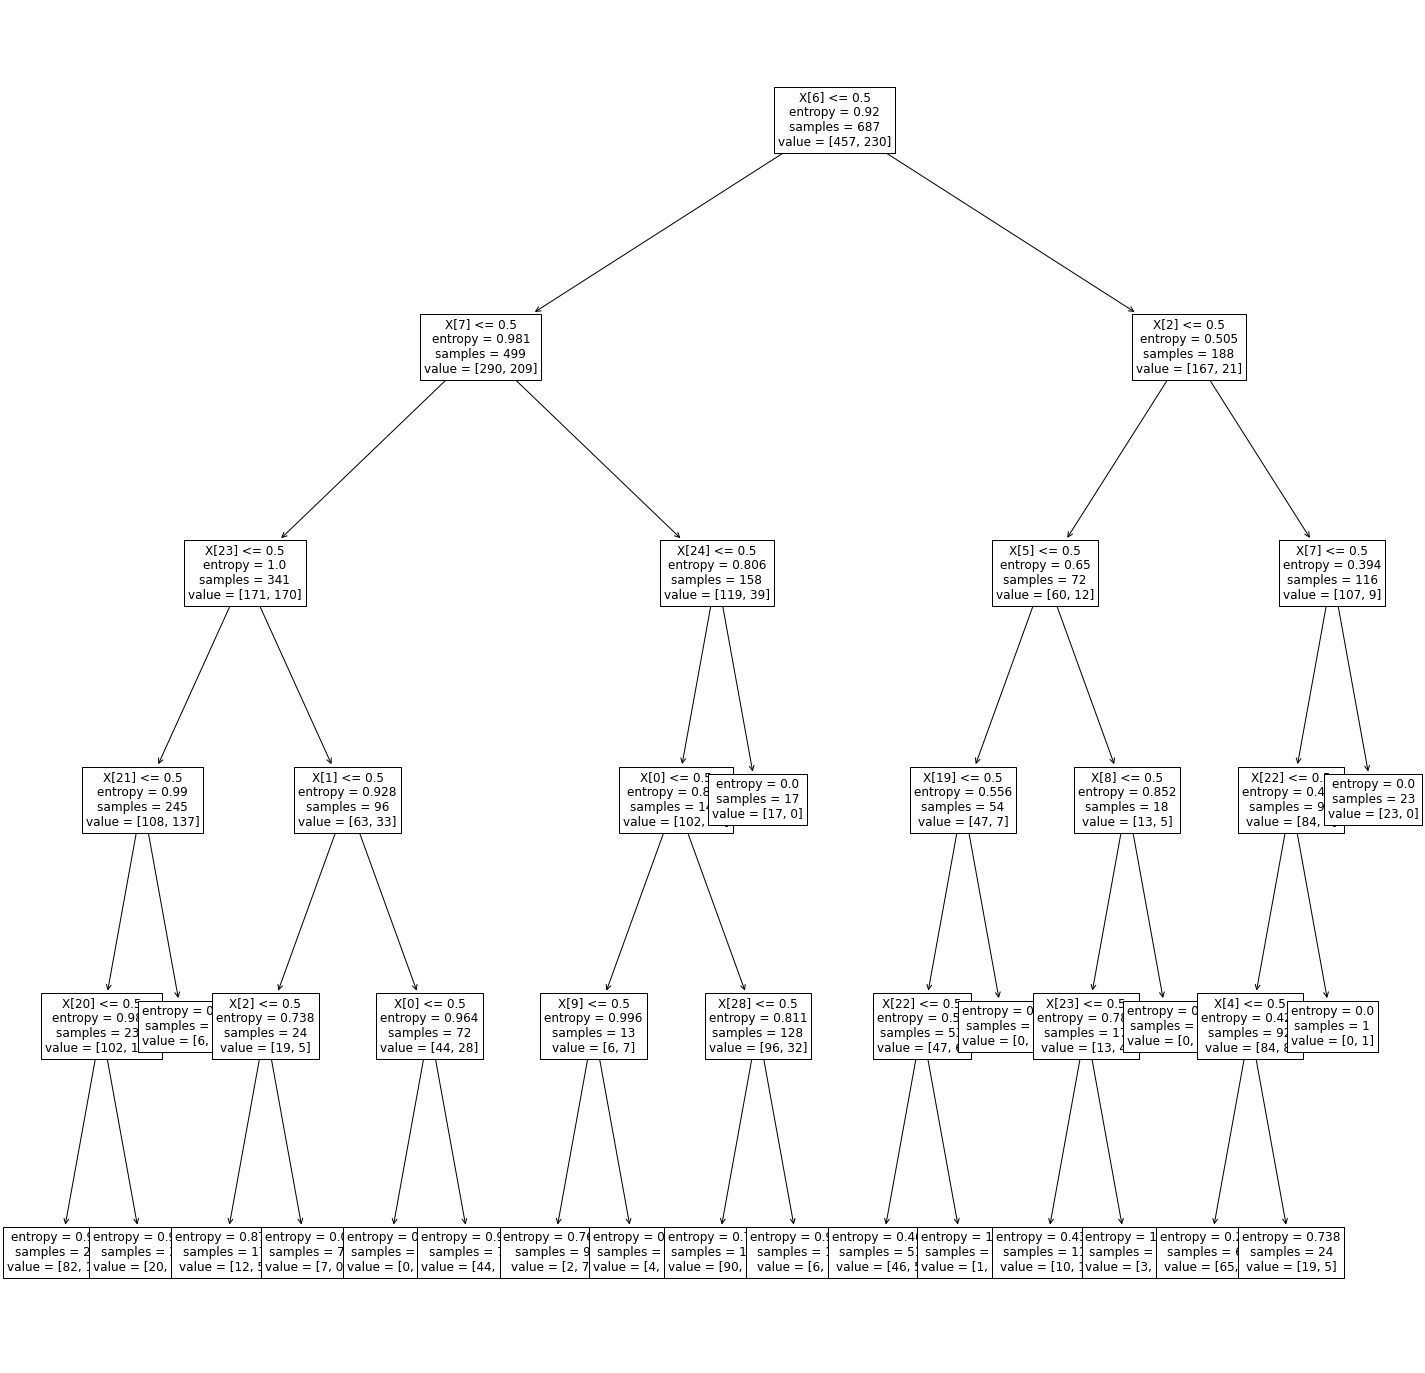

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25, 25))
tree.plot_tree(clf, ax=ax, fontsize=12)
plt.show()


# 評估模型

In [ ]:
clf.score(x_test,y_test)

0.6826086956521739